# Tuning XGBoost hyper-parameters with heuristic search  
# Showcasing this through Credit Card Fraud Detection


The purpose of this experiment is to show how heuristics such as [Simulated Annealing](https://en.wikipedia.org/wiki/Simulated_annealing "Simulated Annealing") can be used to find efficiently good combinations of hyper-parameters in machine learning algorithms. This approach is better than blind random generation of parameters. It is also preferable to fine-tuning each hyper-parameter separately because typically there are interactions between them. 

The XGBoost algorithm is a good show case because it has many hyper-parameters. Exhaustive grid search can be computationally prohibitive.   

## Loading the data

This is a Kaggle dataset taken from [here](https://www.kaggle.com/dalpozz/creditcardfraud "Kaggle dataset") which contains credit card transactions data and a fraud flag. There is a Time variable (seconds from the first transaction in the dataset), an Amount variable, the Class variable (1=fraud, 0= no fraud) and the rest (V1-V28) are factor variables obtained through Principal Components Analysis from the original variables.

The main objective in this experiment is to show that the heuristic search finds a suitable set of hyper-parameters out of a quite large set of potential combinations.

We can verify below that this is a highly imbalanced dataset, typical of fraud detection data. We will take this into account when setting the weights of observations in XGBoost parameters. 

Since we have plenty of data we are going to calibrate the hyper-parameters on a validation dataset and evaluate performance on an unseen testing dataset. 

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(1234)

plt.style.use('ggplot')

dat = pd.read_csv('creditcard.csv')

print(dat.head())
print('\nThe distribution of the target variable:\n')
dat['Class'].value_counts()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Class
0    284315
1       492
Name: count, dtype: int64

## Data exploration.

Although the context of most of the variables is not known (recall that V1-V28 are factors summarizing the transactional data), we know that V1-V28 are by construction standardized, with a mean of 0 and and a standard deviation of 1. We standardize the Time and Amount variables too.

The data exploration and in particular Welch’s t-tests reveal that almost all the factors are significantly associated with the Class variable. The mean of these variables is almost zero in Class 0 and clearly non-zero in Class 1. The Time and Amount variables are also significant. There does not seem to by any reason for variable selection yet. We could drop the Time variable which is probably useless.

Some of the factors (and the Amount variable) are quite skewed and have very thin distributions. If we were to apply some other method (say, logistic regression) we could apply some transformations (and probably binning) but XGBoost is insensitive to such deviations from normality.  


Means of variables in the two Class categories:

Class          0         1
Amount -0.000234  0.135382
Time    0.000513 -0.296223
V1      0.008258 -4.771948
V10     0.009824 -5.676883
V11    -0.006576  3.800173
V12     0.010832 -6.259393
V13     0.000189 -0.109334
V14     0.012064 -6.971723
V15     0.000161 -0.092929
V16     0.007164 -4.139946
V17     0.011535 -6.665836
V18     0.003887 -2.246308
V19    -0.001178  0.680659
V2     -0.006271  3.623778
V20    -0.000644  0.372319
V21    -0.001235  0.713588
V22    -0.000024  0.014049
V23     0.000070 -0.040308
V24     0.000182 -0.105130
V25    -0.000072  0.041449
V26    -0.000089  0.051648
V27    -0.000295  0.170575
V28    -0.000131  0.075667
V3      0.012171 -7.033281
V4     -0.007860  4.542029
V5      0.005453 -3.151225
V6      0.002419 -1.397737
V7      0.009637 -5.568731
V8     -0.000987  0.570636
V9      0.004467 -2.581123

P-values of Welch’s t-tests and shape statistics:

Variable: Time   p-value:  0.000  skewness: -0.036  kurtosis:

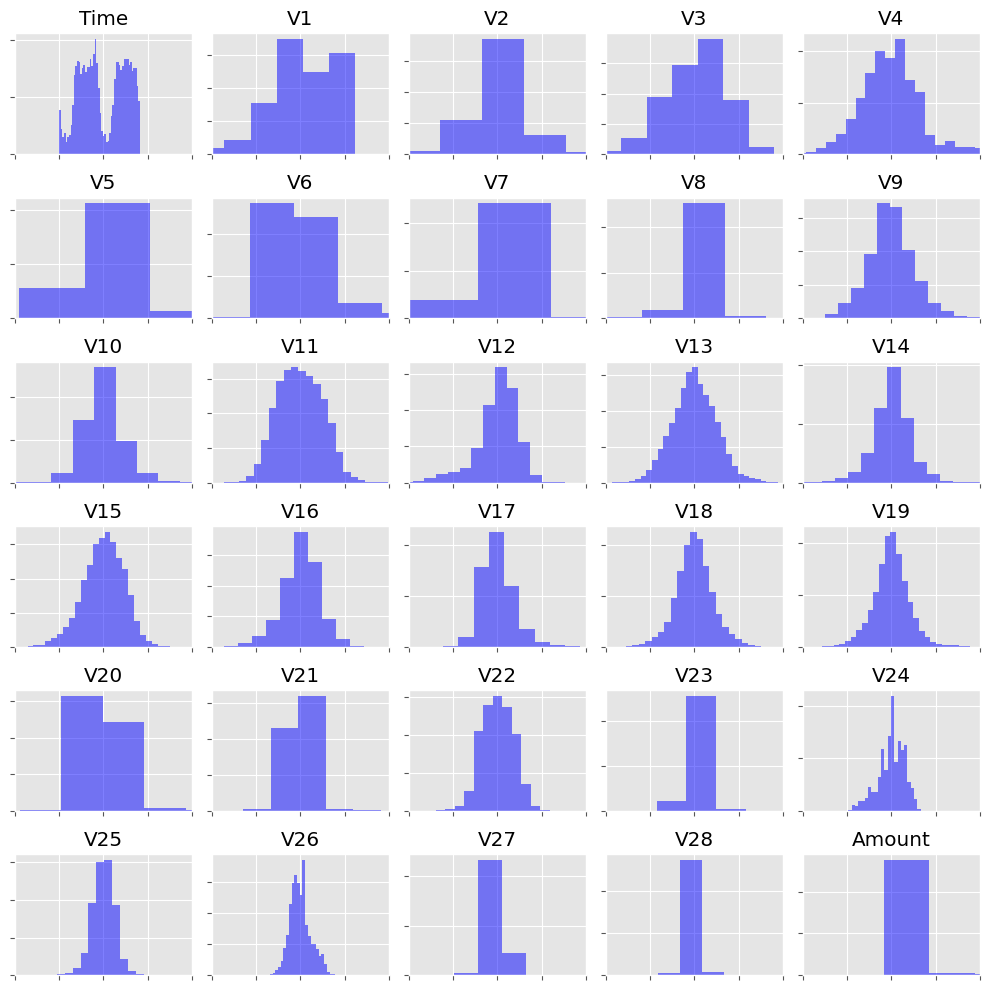

In [7]:
from scipy import stats
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt

# Standardize 'Time' and 'Amount'
dat['Time'] = preprocessing.scale(dat['Time'])
dat['Amount'] = preprocessing.scale(dat['Amount'])

# Exclude 'Class' from the values
numeric_columns = dat.columns.drop('Class')

# Create the pivot table
print('\nMeans of variables in the two Class categories:\n')
pt = pd.pivot_table(dat, values=numeric_columns, columns='Class', aggfunc='mean')
print(pt)

# Perform Welch’s t-tests and calculate shape statistics
print('\nP-values of Welch’s t-tests and shape statistics:\n')
for i in range(len(numeric_columns)):
    col_name = numeric_columns[i]
    t, p_val = stats.ttest_ind(dat.loc[dat['Class'] == 0, col_name], dat.loc[dat['Class'] == 1, col_name], equal_var=False)  
    skewness = dat.loc[:, col_name].skew()
    kurtosis = stats.kurtosis(dat.loc[:, col_name])
    print('Variable: {:7s}'.format(col_name), end='')    
    print('p-value: {:6.3f}  skewness: {:6.3f}  kurtosis: {:6.3f}'.format(p_val, skewness, kurtosis))

# Plot histograms of all variables
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))
axes = axes.flatten()

for i in range(len(numeric_columns)):
    axes[i].hist(dat[numeric_columns[i]], bins=50, facecolor='b', alpha=0.5)
    axes[i].set_title(numeric_columns[i])
    axes[i].set_xlim([-4., +4.])
    plt.setp(axes[i].get_xticklabels(), visible=False) 
    plt.setp(axes[i].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()



## Data partitioning.

In this step, we partition the dataset into 40% training, 30% validation and 30% testing. We also make the corresponding matrices **train**, **valid** and **test** containing predictors only with labels **trainY**, **validY** and **testY**, respectively.

In [9]:


Class = dat['Class'].values

allIndices = np.arange(len(Class))
np.random.shuffle(allIndices) ## shuffle the indices of the observations

numTrain = int(round(0.40*len(Class)))
numValid = int(round(0.30*len(Class)))
numTest = len(Class)-numTrain-numValid

inTrain = allIndices[:numTrain]
inValid = allIndices[numTrain:(numTrain+numValid)]
inTest =  allIndices[(numTrain+numValid):]

train = dat.iloc[inTrain,:30]
valid= dat.iloc[inValid,:30]
test =  dat.iloc[inTest,:30]

trainY = Class[inTrain]
validY = Class[inValid]
testY = Class[inTest]

## Preparing the Booster: Fixed parameters.

First we create the matrices in the format required by XGBoost with the xgb.DMatrix() function, passing for each dataset the predictors data and the labels. Then we set some fixed parameters. The number of boosting iterations (num_rounds) is set to 20. 

We initialize the **param dictionary** with silent=1 (no messages). Parameter min_child_weight is set at the default value of 1 because the data is highly unbalanced. This is the minimum weighted number of observations in a child node for further partitioning. The objective is binary classification and the evaluation metric is the Area Under Curve (AUC), the default for binary classification. The internal random numbers seed is set to a constant for reproducible results (this is not guaranteed though, among other reasons because XGBoost runs in threads).     

We are going to **expand the param dictionary** with the parameters in the heuristic search.

In [13]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
import xgboost as xgb

dtrain = xgb.DMatrix(train, label=trainY)
dvalid = xgb.DMatrix(valid, label=validY)
dtest = xgb.DMatrix(test, label=testY)

## fixed parameters
num_rounds=20 # number of boosting iterations

param = {'silent':1,
         'min_child_weight':1,
         'objective':'binary:logistic',
         'eval_metric':'auc',
         'seed' : 1234}  

## Preparing the Booster: Variable parameters 

We select several important parameters for the heuristic search:

* **max_depth**: the maximum depth of a tree, in [1,∞], with default value 6. We choose to explore also larger values and select 5-25 levels in steps of 5.
* **subsample**, in (0,1] with default value 1. This is the proportion of the training instances used in trees and smaller values can prevent over-fitting. We decide to test values in 0.5-1.0 in steps of 0.1.
* **colsample_bytree**, in (0,1] with default value 1. This is the subsample ratio of columns (features) used to construct a tree. We will try similar values as with subsample.
* **eta** (or **learning_rate**), in [0,1], with default value 0.3. This is the shrinking rate of the feature weights and larger values (but not too high!) can be used to prevent overfitting. We can select some values in [0.01,0.4].
* **gamma**, in [0, ∞], with default value 0. This is the minimum loss function reduction required for a split.  We can experiment with values in 0-2 in steps of 0.05.
* **scale_pos_weight** which controls the balance of positive and negative weights with default value 1. We use the ratio of negative to positive cases which is 565 here, i.e. to put a weight that large to the positive cases.  We can try some small values and some larger ones. 


The **total number of possible combinations** is 43200 and we are only going to test a small fraction of 100 of them, i.e. as many as the number of the heuristic search iterations. 

We also initialize a dataframe which will hold the results, for later examination.


In [17]:

from collections import OrderedDict

ratio_neg_to_pos = sum(trainY==0)/sum(trainY==1)  ## = 608
print('Ratio of negative to positive instances: {:6.1f}'.format(ratio_neg_to_pos))

## parameters to be tuned
tune_dic = OrderedDict()

tune_dic['max_depth']= [5,10,15,20,25] ## maximum tree depth
tune_dic['subsample']=[0.5,0.6,0.7,0.8,0.9,1.0] ## proportion of training instances used in trees
tune_dic['colsample_bytree']= [0.5,0.6,0.7,0.8,0.9,1.0] ## subsample ratio of columns
tune_dic['eta']= [0.01,0.05,0.10,0.20,0.30,0.40]  ## learning rate
tune_dic['gamma']= [0.00,0.05,0.10,0.15,0.20]  ## minimum loss function reduction required for a split
tune_dic['scale_pos_weight']=[30,40,50,300,400,500,600,700] ## relative weight of positive/negative instances

lengths = [len(lst) for lst in tune_dic.values()]

combs=1
for i in range(len(lengths)):
    combs *= lengths[i]
print('Total number of combinations: {:16d}'.format(combs))  

maxiter=100

columns=[*tune_dic.keys()]+['F-Score','Best F-Score']
results = pd.DataFrame(index=range(maxiter), columns=columns) ## dataframe to hold training results


Ratio of negative to positive instances:  565.8
Total number of combinations:            43200


## Functions for training and performance reporting.

Next we define two functions:

Function **perf_measures()** accepts some predictions and labels, optionally prints the confusion matrix, and returns the [F-Score](https://en.wikipedia.org/wiki/F1_score "F-Score") This is a measure of performance combining [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall "Precision and recall") and will guide the heuristic search.

Function **do_train()** accepts as parameters:  
- the current choice of variable parameters in a dictionary (cur_choice),   
- the full dictionary of parameters to be passed to the main XGBoost training routine (param),   
- a train dataset in XGBoost format (train),   
- a string identifier (train_s),   
- its labels (trainY),  
- the corresponding arguments for a validation dataset (valid, valid_s, validY),  
- and the option to print the confusion matrix (print_conf_matrix). 

It then trains the model and returns the F-score of the predictions on the validation dataset together with the model. The call to the main train routine **xgb.train()** has the following arguments:   
- the full dictionary of the parameters (param),    
- the train dataset in XGBoost format (train),  
- the number of boosting iterations  (num_boost),  
- [ a watchlist with datasets information to show progress (evals) ] --> this is commented-out below. 


In [19]:
def perf_measures(preds, labels, print_conf_matrix=False):
    
    act_pos=sum(labels==1) ## actual positive
    act_neg=len(labels) - act_pos ## actual negative
    
    pred_pos=sum(1 for i in range(len(preds)) if (preds[i]>=0.5)) ## predicted positive
    true_pos=sum(1 for i in range(len(preds)) if (preds[i]>=0.5) & (labels[i]==1)) ## predicted negative
    
    false_pos=pred_pos - true_pos ## false positive
    false_neg=act_pos-true_pos ## false negative
    true_neg=act_neg-false_pos ## true negative

    precision = true_pos / pred_pos if pred_pos > 0 else 0 ## tp/(tp+fp) percentage of correctly classified predicted positives
    recall = true_pos / act_pos if act_pos > 0 else 0 ## tp/(tp+fn) percentage of positives correctly classified
      
    f_score = 2*precision*recall/(precision+recall) 
    
    if print_conf_matrix:
        print('\nconfusion matrix')
        print('----------------')
        print( 'tn:{:6d} fp:{:6d}'.format(true_neg,false_pos))
        print( 'fn:{:6d} tp:{:6d}'.format(false_neg,true_pos))
    
    return(f_score)


def do_train(cur_choice, param, train,train_s,trainY,valid,valid_s,validY,print_conf_matrix=False):
    ## train with given fixed and variable parameters
    ## and report the F-score on the validation dataset
    
    print('Parameters:')
    for (key,value) in cur_choice.items():
        print(key,': ',value,' ',end='')
        param[key]=value
    print('\n')    
    
##    the commented-out segment below uses a watchlist to monitor the progress of the boosting iterations 
##    evallist  = [(train,train_s), (valid,valid_s)]
##    model = xgb.train( param, train, num_boost_round=num_rounds,
##                      evals=evallist,verbose_eval=False)  
    
    model = xgb.train( param, train, num_boost_round=num_rounds)  
    
    preds = model.predict(valid)
    labels = valid.get_label()
      
    f_score = perf_measures(preds, labels,print_conf_matrix)
    
    return(f_score, model)    


## Producing neighboring combinations.

Next we define a function next_choice() which either produces a random combination of the variable parameters (if no current parameters are passed with cur_params) or generates a neighboring combination of the parameters passed in cur_params.   

In the second case we first select at random a parameter to be changed. Then:
* If this parameter currently has the smallest value, we select the next (larger) one.
* If this parameter currently has the largest value, we select the previous (smaller) one.
* Otherwise, we select the left (smaller) or right (larger) value randomly.

Repetitions are avoided in the function which carries out the heuristic search.

In [21]:


def next_choice(cur_params=None):
    ## returns a random combination of the variable parameters (if cur_params=None)
    ## or a random neighboring combination from cur_params
    if cur_params:
        ## chose parameter to change
        ## parameter name and current value
        choose_param_name, cur_value = random.choice(list(cur_params.items())) ## parameter name 
       
        all_values =  list(tune_dic[choose_param_name]) ## all values of selected parameter
        cur_index = all_values.index(cur_value) ## current index of selected parameter
        
        
        if cur_index==0: ## if it is the first in the range select the second one
            next_index=1
        elif cur_index==len(all_values)-1: ## if it is the last in the range select the previous one
            next_index=len(all_values)-2
        else: ## otherwise select the left or right value randomly
            direction=np.random.choice([-1,1])
            next_index=cur_index + direction

        next_params = dict((k,v) for k,v in cur_params.items())
        next_params[choose_param_name] = all_values[next_index] ## change the value of the selected parameter
        print('selected move: {:10s}: from {:6.2f} to {:6.2f}'.
              format(choose_param_name, cur_value, all_values[next_index] ))
    else: ## generate a random combination of parameters
        next_params=dict()
        for i in range(len(tune_dic)):
            key = [*tune_dic.keys()][i] 
            values = [*tune_dic.values()][i]
            next_params[key] = np.random.choice(values)
    return(next_params)  


## Application of the Simulated Annealing algorithm.

At each iteration of the Simulated Annealing algorith, one combination of hyper-parameters is selected. The XGBoost algorithm is trained with these parameters and the F-score on the validation set is produced. 

* If this F-score is better (larger) than the one at the previous iteration, i.e. there is a "local" improvement, the combination is accepted as the current combination and a neighbouring combination is selected for the next iteration through a call to the next_choice() function.
* Otherwise, i.e. if this F-score is worse (smaller) than the one at the previous iteration and the decline is Δf < 0, the combination is accepted as the current one with probability exp(-beta Δf/T) where beta is a constant and T is the current "temperature". The idea is that we start with a high temperature and "bad" solutions are easily accepted at first, in the hope of exploring wide areas of the search space. But as the temperature drops, bad solutions are less likely to be accepted and the search becomes more focused.      

The temperature starts at a fixed value T0 and is reduced by a factor of alpha < 1 every n number of iterations. Here T0 = 0.40, n=5 and alpha = 0.85. The beta constant is 1.3.  

Repetitions are avoided with a simple hashing scheme.



In [29]:
import time

t0 = time.time()

T=0.40
best_params = dict() ## initialize dictionary to hold the best parameters

best_f_score = -1. ## initialize best f-score
prev_f_score = -1. ## initialize previous f-score
prev_choice = None ## initialize previous selection of parameters
weights = list(map(lambda x: 10**x, [0,1,2,3,4])) ## weights for the hash function
hash_values=set()

for iter in range(maxiter):
    print('\nIteration = {:5d}  T = {:12.6f}'.format(iter,T))

    ## find next selection of parameters not visited before
    while True:
        cur_choice=next_choice(prev_choice) ## first selection or selection-neighbor of prev_choice
         
        ## indices of the selections in alphabetical order of the parameters    
        indices=[tune_dic[name].index(cur_choice[name]) for name in sorted([*tune_dic.keys()])]
        
        ## check if selection has already been visited
        hash_val = sum([i*j for (i, j) in zip(weights, indices)])
        if hash_val in hash_values:
            print('\nCombination revisited - searching again')

#        tmp=abs(results.loc[:,[*cur_choice.keys()]] - list(cur_choice.values()))
#        tmp=tmp.sum(axis=1)
#        if any(tmp==0): ## selection has already been visited
#            print('\nCombination revisited - searching again')
        else:
            hash_values.add(hash_val)
            break ## break out of the while-loop
    
    
    ## train the model and obtain f-score on the validation dataset
    f_score,model=do_train(cur_choice, param, dtrain,'train',trainY,dvalid,'valid',validY)
    
    ## store the parameters
    results.loc[iter,[*cur_choice.keys()]]=list(cur_choice.values())
    
    print('    F-Score: {:6.2f}  previous: {:6.2f}  best so far: {:6.2f}'.format(f_score, prev_f_score, best_f_score))
 
    if f_score > prev_f_score:
        print('    Local improvement')
        
        ## accept this combination as the new starting point
        prev_f_score = f_score
        prev_choice = cur_choice
        
        ## update best parameters if the f-score is globally better
        if f_score > best_f_score:
            
            best_f_score = f_score
            print('    Global improvement - best f-score updated')
            for (key,value) in prev_choice.items():
                best_params[key]=value

    else: ## f-score is smaller than the previous one
        
        ## accept this combination as the new starting point with probability exp(-(1.6 x f-score decline)/temperature) 
        rnd = random.random()
        diff = f_score-prev_f_score
        thres=np.exp(1.3*diff/T)
        if rnd <= thres:
            print('    Worse result. F-Score change: {:8.4f}  threshold: {:6.4f}  random number: {:6.4f} -> accepted'.
                  format(diff, thres, rnd))
            prev_f_score = f_score
            prev_choice = cur_choice
 
        else:
            ## do not update previous f-score and previous choice
            print('    Worse result. F-Score change: {:8.4f}  threshold: {:6.4f}  random number: {:6.4f} -> rejected'.
                 format(diff, thres, rnd))
    ## store results
    results.loc[iter,'F-Score']=f_score
    results.loc[iter,'Best F-Score']=best_f_score
    if iter % 5 == 0: T=0.85*T  ## reduce temperature every 5 iterations and continue 
        
print('\n{:6.1f} minutes process time\n'.format((time.time() - t0)/60))    

print('Best variable parameters found:\n')
print(best_params)


Iteration =     0  T =     0.400000
Parameters:
max_depth :  25  subsample :  0.6  colsample_bytree :  1.0  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:  -1.00  best so far:  -1.00
    Local improvement
    Global improvement - best f-score updated

Iteration =     1  T =     0.340000
selected move: colsample_bytree: from   1.00 to   0.90
Parameters:
max_depth :  25  subsample :  0.6  colsample_bytree :  0.9  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.84  best so far:   0.84
    Local improvement
    Global improvement - best f-score updated

Iteration =     2  T =     0.340000
selected move: max_depth : from  25.00 to  20.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.85  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.0733 -> accepted

Iteration =     3  T =     0.340000
selected move: eta       : from   0.20 to   0.10
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.85  best so far:   0.85
    Worse result. F-Score change:  -0.0205  threshold: 0.9248  random number: 0.2984 -> accepted

Iteration =     4  T =     0.340000
selected move: scale_pos_weight: from  40.00 to  30.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.1  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Local improvement

Iteration =     5  T =     0.340000
selected move: eta       : from   0.10 to   0.05
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.05  gamma :  0.1  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.81  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:  -0.0171  threshold: 0.9369  random number: 0.1856 -> accepted

Iteration =     6  T =     0.289000
selected move: scale_pos_weight: from  30.00 to  40.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.05  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.81  best so far:   0.85
    Local improvement

Iteration =     7  T =     0.289000
selected move: eta       : from   0.05 to   0.01
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.01  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/vk/m4r2s6m50fd3n64d8468pk680000gn/T/ipykernel_57181/3390642874.py:16: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall/(precision+recall)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:    nan  previous:   0.82  best so far:   0.85
    Worse result. F-Score change:      nan  threshold:    nan  random number: 0.1572 -> rejected

Iteration =     8  T =     0.289000
selected move: gamma     : from   0.10 to   0.15
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.05  gamma :  0.15  scale_pos_weight :  40  

    F-Score:   0.82  previous:   0.82  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.3695 -> accepted

Iteration =     9  T =     0.289000
selected move: gamma     : from   0.15 to   0.10

Combination revisited - searching again
selected move: colsample_bytree: from   0.90 to   1.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  1.0  eta :  0.05  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.82  best so far:   0.85
    Worse result. F-Score change:  -0.0033  threshold: 0.9852  random number: 0.2061 -> accepted

Iteration =    10  T =     0.289000
selected move: gamma     : from   0.15 to   0.20
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  1.0  eta :  0.05  gamma :  0.2  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.82  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.9962 -> accepted

Iteration =    11  T =     0.245650
selected move: gamma     : from   0.20 to   0.15

Combination revisited - searching again
selected move: eta       : from   0.05 to   0.10
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  1.0  eta :  0.1  gamma :  0.2  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.82  best so far:   0.85
    Local improvement

Iteration =    12  T =     0.245650
selected move: scale_pos_weight: from  40.00 to  30.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  1.0  eta :  0.1  gamma :  0.2  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.85
    Worse result. F-Score change:  -0.0092  threshold: 0.9527  random number: 0.4744 -> accepted

Iteration =    13  T =     0.245650
selected move: max_depth : from  20.00 to  25.00
Parameters:
max_depth :  25  subsample :  0.6  colsample_bytree :  1.0  eta :  0.1  gamma :  0.2  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.8013 -> accepted

Iteration =    14  T =     0.245650
selected move: scale_pos_weight: from  30.00 to  40.00
Parameters:
max_depth :  25  subsample :  0.6  colsample_bytree :  1.0  eta :  0.1  gamma :  0.2  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.83  best so far:   0.85
    Local improvement

Iteration =    15  T =     0.245650
selected move: eta       : from   0.10 to   0.05
Parameters:
max_depth :  25  subsample :  0.6  colsample_bytree :  1.0  eta :  0.05  gamma :  0.2  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.84  best so far:   0.85
    Worse result. F-Score change:  -0.0167  threshold: 0.9156  random number: 0.6607 -> accepted

Iteration =    16  T =     0.208803
selected move: max_depth : from  25.00 to  20.00

Combination revisited - searching again
selected move: max_depth : from  25.00 to  20.00

Combination revisited - searching again
selected move: colsample_bytree: from   1.00 to   0.90
Parameters:
max_depth :  25  subsample :  0.6  colsample_bytree :  0.9  eta :  0.05  gamma :  0.2  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.82  best so far:   0.85
    Local improvement

Iteration =    17  T =     0.208803
selected move: eta       : from   0.05 to   0.10
Parameters:
max_depth :  25  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.2  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.82  best so far:   0.85
    Local improvement

Iteration =    18  T =     0.208803
selected move: max_depth : from  25.00 to  20.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.2  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.9161 -> accepted

Iteration =    19  T =     0.208803
selected move: gamma     : from   0.20 to   0.15
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.3318 -> accepted

Iteration =    20  T =     0.208803
selected move: colsample_bytree: from   0.90 to   1.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  1.0  eta :  0.1  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.83  best so far:   0.85
    Local improvement

Iteration =    21  T =     0.177482
selected move: colsample_bytree: from   1.00 to   0.90

Combination revisited - searching again
selected move: colsample_bytree: from   1.00 to   0.90

Combination revisited - searching again
selected move: scale_pos_weight: from  40.00 to  30.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  1.0  eta :  0.1  gamma :  0.15  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.85
    Worse result. F-Score change:  -0.0092  threshold: 0.9351  random number: 0.6861 -> accepted

Iteration =    22  T =     0.177482
selected move: colsample_bytree: from   1.00 to   0.90
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.15  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.5629 -> accepted

Iteration =    23  T =     0.177482
selected move: colsample_bytree: from   0.90 to   0.80
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.15  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Local improvement

Iteration =    24  T =     0.177482
selected move: gamma     : from   0.15 to   0.10
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.1  scale_pos_weight :  30  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.1946 -> accepted

Iteration =    25  T =     0.177482
selected move: scale_pos_weight: from  30.00 to  40.00
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:  -0.0046  threshold: 0.9665  random number: 0.2790 -> accepted

Iteration =    26  T =     0.150860
selected move: gamma     : from   0.10 to   0.15
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.85
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.6936 -> accepted

Iteration =    27  T =     0.150860
selected move: subsample : from   0.60 to   0.50

Combination revisited - searching again
selected move: colsample_bytree: from   0.80 to   0.90

Combination revisited - searching again
selected move: gamma     : from   0.15 to   0.10

Combination revisited - searching again
selected move: colsample_bytree: from   0.80 to   0.70
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.7  eta :  0.1  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.83  best so far:   0.85
    Local improvement
    Global improvement - best f-score updated

Iteration =    28  T =     0.150860
selected move: colsample_bytree: from   0.70 to   0.80

Combination revisited - searching again
selected move: eta       : from   0.10 to   0.20
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.86  previous:   0.85  best so far:   0.85
    Local improvement
    Global improvement - best f-score updated

Iteration =    29  T =     0.150860
selected move: colsample_bytree: from   0.70 to   0.60
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.86  best so far:   0.86
    Worse result. F-Score change:  -0.0125  threshold: 0.8977  random number: 0.0850 -> accepted

Iteration =    30  T =     0.150860
selected move: gamma     : from   0.15 to   0.10
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.5892 -> accepted

Iteration =    31  T =     0.128231
selected move: gamma     : from   0.10 to   0.15

Combination revisited - searching again
selected move: max_depth : from  20.00 to  15.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.8241 -> accepted

Iteration =    32  T =     0.128231
selected move: colsample_bytree: from   0.60 to   0.70
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.84  best so far:   0.86
    Local improvement

Iteration =    33  T =     0.128231
selected move: colsample_bytree: from   0.70 to   0.80
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.8  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.85  best so far:   0.86
    Local improvement

Iteration =    34  T =     0.128231
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: max_depth : from  15.00 to  10.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.2  gamma :  0.1  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.85  best so far:   0.86
    Worse result. F-Score change:  -0.0091  threshold: 0.9123  random number: 0.3945 -> accepted

Iteration =    35  T =     0.128231
selected move: scale_pos_weight: from  40.00 to  50.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.2  gamma :  0.1  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.85  best so far:   0.86
    Local improvement

Iteration =    36  T =     0.108996
selected move: max_depth : from  10.00 to  15.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.8  eta :  0.2  gamma :  0.1  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.85  best so far:   0.86
    Worse result. F-Score change:  -0.0078  threshold: 0.9107  random number: 0.9738 -> rejected

Iteration =    37  T =     0.108996
selected move: scale_pos_weight: from  50.00 to  40.00

Combination revisited - searching again
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: colsample_bytree: from   0.80 to   0.70
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.1  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.85  best so far:   0.86
    Worse result. F-Score change:  -0.0124  threshold: 0.8624  random number: 0.5157 -> accepted

Iteration =    38  T =     0.108996
selected move: eta       : from   0.20 to   0.30
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.3  gamma :  0.1  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    39  T =     0.108996
selected move: gamma     : from   0.10 to   0.05
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.3  gamma :  0.05  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0021  threshold: 0.9758  random number: 0.9075 -> accepted

Iteration =    40  T =     0.108996
selected move: colsample_bytree: from   0.70 to   0.60
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.3  gamma :  0.05  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.84  best so far:   0.86
    Local improvement

Iteration =    41  T =     0.092647
selected move: colsample_bytree: from   0.60 to   0.70

Combination revisited - searching again
selected move: scale_pos_weight: from  50.00 to 300.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.3  gamma :  0.05  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.85  best so far:   0.86
    Worse result. F-Score change:  -0.0119  threshold: 0.8458  random number: 0.4856 -> accepted

Iteration =    42  T =     0.092647
selected move: gamma     : from   0.05 to   0.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.3  gamma :  0.0  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Local improvement

Iteration =    43  T =     0.092647
selected move: subsample : from   0.60 to   0.50

Combination revisited - searching again
selected move: colsample_bytree: from   0.60 to   0.50
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.5  eta :  0.3  gamma :  0.0  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0044  threshold: 0.9395  random number: 0.5044 -> accepted

Iteration =    44  T =     0.092647
selected move: scale_pos_weight: from 300.00 to 400.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.5  eta :  0.3  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0019  threshold: 0.9735  random number: 0.9105 -> accepted

Iteration =    45  T =     0.092647
selected move: max_depth : from  10.00 to   5.00
Parameters:
max_depth :  5  subsample :  0.6  colsample_bytree :  0.5  eta :  0.3  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.64  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.1915  threshold: 0.0681  random number: 0.6828 -> rejected

Iteration =    46  T =     0.078750
selected move: colsample_bytree: from   0.50 to   0.60
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.3  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    47  T =     0.078750
selected move: gamma     : from   0.00 to   0.05
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.3  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.85  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.2296 -> accepted

Iteration =    48  T =     0.078750
selected move: eta       : from   0.30 to   0.20
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.85  best so far:   0.86
    Worse result. F-Score change:  -0.0089  threshold: 0.8638  random number: 0.4994 -> accepted

Iteration =    49  T =     0.078750
selected move: scale_pos_weight: from 400.00 to 300.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.05  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0154  threshold: 0.7757  random number: 0.9502 -> rejected

Iteration =    50  T =     0.078750
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: gamma     : from   0.05 to   0.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.6226 -> accepted

Iteration =    51  T =     0.066937
selected move: max_depth : from  10.00 to  15.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0228  threshold: 0.6425  random number: 0.1455 -> accepted

Iteration =    52  T =     0.066937
selected move: subsample : from   0.60 to   0.50

Combination revisited - searching again
selected move: scale_pos_weight: from 400.00 to 500.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.0  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.82  best so far:   0.86
    Local improvement

Iteration =    53  T =     0.066937
selected move: subsample : from   0.60 to   0.50

Combination revisited - searching again
selected move: gamma     : from   0.00 to   0.05
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.05  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0027  threshold: 0.9484  random number: 0.7544 -> accepted

Iteration =    54  T =     0.066937
selected move: scale_pos_weight: from 500.00 to 400.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.6  eta :  0.2  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.82  best so far:   0.86
    Worse result. F-Score change:  -0.0078  threshold: 0.8587  random number: 0.7734 -> accepted

Iteration =    55  T =     0.066937
selected move: colsample_bytree: from   0.60 to   0.70
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.82  best so far:   0.86
    Local improvement

Iteration =    56  T =     0.056897
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: scale_pos_weight: from 400.00 to 300.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.05  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.82  best so far:   0.86
    Local improvement

Iteration =    57  T =     0.056897
selected move: gamma     : from   0.05 to   0.10
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.1  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.5662 -> accepted

Iteration =    58  T =     0.056897
selected move: gamma     : from   0.10 to   0.15
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.15  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.5992 -> accepted

Iteration =    59  T =     0.056897
selected move: eta       : from   0.20 to   0.30
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.7  eta :  0.3  gamma :  0.15  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    60  T =     0.056897
selected move: max_depth : from  15.00 to  10.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.3  gamma :  0.15  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0019  threshold: 0.9572  random number: 0.3717 -> accepted

Iteration =    61  T =     0.048362
selected move: colsample_bytree: from   0.70 to   0.80
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.3  gamma :  0.15  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0045  threshold: 0.8867  random number: 0.7629 -> accepted

Iteration =    62  T =     0.048362
selected move: scale_pos_weight: from 300.00 to 400.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.3  gamma :  0.15  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0032  threshold: 0.9186  random number: 0.4084 -> accepted

Iteration =    63  T =     0.048362
selected move: max_depth : from  10.00 to  15.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.8  eta :  0.3  gamma :  0.15  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.82  best so far:   0.86
    Local improvement

Iteration =    64  T =     0.048362
selected move: gamma     : from   0.15 to   0.10
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.8  eta :  0.3  gamma :  0.1  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.6120 -> accepted

Iteration =    65  T =     0.048362
selected move: colsample_bytree: from   0.80 to   0.90
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.9  eta :  0.3  gamma :  0.1  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    66  T =     0.041108
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: gamma     : from   0.10 to   0.05
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.9  eta :  0.3  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.8030 -> accepted

Iteration =    67  T =     0.041108
selected move: colsample_bytree: from   0.90 to   1.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  1.0  eta :  0.3  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0045  threshold: 0.8678  random number: 0.9398 -> rejected

Iteration =    68  T =     0.041108
selected move: gamma     : from   0.05 to   0.10

Combination revisited - searching again
selected move: scale_pos_weight: from 400.00 to 500.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.9  eta :  0.3  gamma :  0.05  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0039  threshold: 0.8847  random number: 0.7691 -> accepted

Iteration =    69  T =     0.041108
selected move: gamma     : from   0.05 to   0.10
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.9  eta :  0.3  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0031  threshold: 0.9059  random number: 0.4928 -> accepted

Iteration =    70  T =     0.041108
selected move: max_depth : from  15.00 to  10.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.9  eta :  0.3  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.80  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0270  threshold: 0.4253  random number: 0.0298 -> accepted

Iteration =    71  T =     0.034942
selected move: max_depth : from  10.00 to   5.00
Parameters:
max_depth :  5  subsample :  0.6  colsample_bytree :  0.9  eta :  0.3  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.72  previous:   0.80  best so far:   0.86
    Worse result. F-Score change:  -0.0874  threshold: 0.0386  random number: 0.8283 -> rejected

Iteration =    72  T =     0.034942
selected move: eta       : from   0.30 to   0.20
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.9  eta :  0.2  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.81  previous:   0.80  best so far:   0.86
    Local improvement

Iteration =    73  T =     0.034942
selected move: colsample_bytree: from   0.90 to   1.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  1.0  eta :  0.2  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.81  best so far:   0.86
    Local improvement

Iteration =    74  T =     0.034942
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: eta       : from   0.20 to   0.30
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  1.0  eta :  0.3  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0132  threshold: 0.6124  random number: 0.6769 -> rejected

Iteration =    75  T =     0.034942
selected move: scale_pos_weight: from 500.00 to 400.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  1.0  eta :  0.2  gamma :  0.1  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0207  threshold: 0.4625  random number: 0.2420 -> accepted

Iteration =    76  T =     0.029700
selected move: max_depth : from  10.00 to  15.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  1.0  eta :  0.2  gamma :  0.1  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.82  best so far:   0.86
    Local improvement

Iteration =    77  T =     0.029700
selected move: scale_pos_weight: from 400.00 to 300.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  1.0  eta :  0.2  gamma :  0.1  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0046  threshold: 0.8178  random number: 0.3566 -> accepted

Iteration =    78  T =     0.029700
selected move: colsample_bytree: from   1.00 to   0.90
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.9  eta :  0.2  gamma :  0.1  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.82  best so far:   0.86
    Local improvement

Iteration =    79  T =     0.029700
selected move: eta       : from   0.20 to   0.10
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.1  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.1740 -> accepted

Iteration =    80  T =     0.029700
selected move: scale_pos_weight: from 300.00 to  50.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.1  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    81  T =     0.025245
selected move: max_depth : from  15.00 to  10.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.1  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.2123 -> accepted

Iteration =    82  T =     0.025245
selected move: subsample : from   0.60 to   0.50

Combination revisited - searching again
selected move: gamma     : from   0.10 to   0.05
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.05  scale_pos_weight :  50  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.6204 -> accepted

Iteration =    83  T =     0.025245
selected move: scale_pos_weight: from  50.00 to 300.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.9  eta :  0.1  gamma :  0.05  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0040  threshold: 0.8152  random number: 0.1415 -> accepted

Iteration =    84  T =     0.025245
selected move: subsample : from   0.60 to   0.50

Combination revisited - searching again
selected move: scale_pos_weight: from 300.00 to  50.00

Combination revisited - searching again
selected move: colsample_bytree: from   0.90 to   0.80
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.05  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0045  threshold: 0.7940  random number: 0.6512 -> accepted

Iteration =    85  T =     0.025245
selected move: max_depth : from  10.00 to  15.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.05  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:  -0.0040  threshold: 0.8140  random number: 0.9385 -> rejected

Iteration =    86  T =     0.021459
selected move: gamma     : from   0.05 to   0.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.0  scale_pos_weight :  300  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.4680 -> accepted

Iteration =    87  T =     0.021459
selected move: gamma     : from   0.00 to   0.05

Combination revisited - searching again
selected move: scale_pos_weight: from 300.00 to 400.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.1  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    88  T =     0.021459
selected move: colsample_bytree: from   0.80 to   0.70
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.1  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    89  T =     0.021459
selected move: colsample_bytree: from   0.70 to   0.60
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.1  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.85  previous:   0.84  best so far:   0.86
    Local improvement

Iteration =    90  T =     0.021459
selected move: eta       : from   0.10 to   0.05
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.6  eta :  0.05  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.85  best so far:   0.86
    Worse result. F-Score change:  -0.0103  threshold: 0.5357  random number: 0.4082 -> accepted

Iteration =    91  T =     0.018240
selected move: colsample_bytree: from   0.60 to   0.70
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.05  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.2342 -> accepted

Iteration =    92  T =     0.018240
selected move: max_depth : from  10.00 to   5.00
Parameters:
max_depth :  5  subsample :  0.6  colsample_bytree :  0.7  eta :  0.05  gamma :  0.0  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.59  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.2438  threshold: 0.0000  random number: 0.8992 -> rejected

Iteration =    93  T =     0.018240
selected move: gamma     : from   0.00 to   0.05
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.05  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.9854 -> accepted

Iteration =    94  T =     0.018240
selected move: max_depth : from  10.00 to   5.00
Parameters:
max_depth :  5  subsample :  0.6  colsample_bytree :  0.7  eta :  0.05  gamma :  0.05  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.59  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.2438  threshold: 0.0000  random number: 0.5442 -> rejected

Iteration =    95  T =     0.018240
selected move: max_depth : from  10.00 to   5.00

Combination revisited - searching again
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: gamma     : from   0.05 to   0.00

Combination revisited - searching again
selected move: gamma     : from   0.05 to   0.10
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.7  eta :  0.05  gamma :  0.1  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.5936 -> accepted

Iteration =    96  T =     0.015504
selected move: gamma     : from   0.10 to   0.05

Combination revisited - searching again
selected move: subsample : from   0.60 to   0.70

Combination revisited - searching again
selected move: colsample_bytree: from   0.70 to   0.80
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.05  gamma :  0.1  scale_pos_weight :  400  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0079  threshold: 0.5154  random number: 0.2929 -> accepted

Iteration =    97  T =     0.015504
selected move: colsample_bytree: from   0.80 to   0.70

Combination revisited - searching again
selected move: scale_pos_weight: from 400.00 to 500.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.05  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.84  previous:   0.83  best so far:   0.86
    Local improvement

Iteration =    98  T =     0.015504
selected move: scale_pos_weight: from 500.00 to 600.00
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.05  gamma :  0.1  scale_pos_weight :  600  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.83  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0076  threshold: 0.5273  random number: 0.6427 -> rejected

Iteration =    99  T =     0.015504
selected move: eta       : from   0.05 to   0.01
Parameters:
max_depth :  10  subsample :  0.6  colsample_bytree :  0.8  eta :  0.01  gamma :  0.1  scale_pos_weight :  500  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


    F-Score:   0.82  previous:   0.84  best so far:   0.86
    Worse result. F-Score change:  -0.0222  threshold: 0.1550  random number: 0.9917 -> rejected

   0.9 minutes process time

Best variable parameters found:

{'max_depth': 20, 'subsample': 0.6, 'colsample_bytree': 0.7, 'eta': 0.2, 'gamma': 0.15, 'scale_pos_weight': 40}


###### Evaluation on the test dataset.

The evaluation on the test dataset results to an F-Score of 0.86 which is considered good given the high imbalance in the classes. The run time was 54 seconds on a Mac system with 8GB RAM and M2 Chip. 

The best hyper-parameters found are in the ranges expected to be good according to all sources. One can then proceed this way:
* Narrowing the ranges of these hyper-parameters,   
* Possibly adding others which are not used here (for example, regularization parameters),
* Possibly doing some variable selection on the basis of the variable importance information,
* Importantly, combining different models, ensemble-like. 


Best parameters found:

{'max_depth': 20, 'subsample': 0.6, 'colsample_bytree': 0.7, 'eta': 0.2, 'gamma': 0.15, 'scale_pos_weight': 40}

Evaluation on the test dataset

Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.7  eta :  0.2  gamma :  0.15  scale_pos_weight :  40  



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)



confusion matrix
----------------
tn: 85278 fp:    10
fn:    30 tp:   124

F-score on the test dataset:   0.86


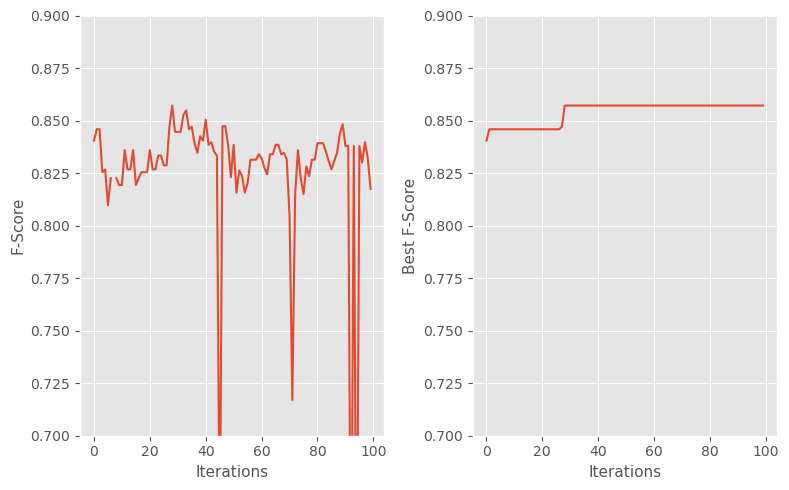


Variables importance:



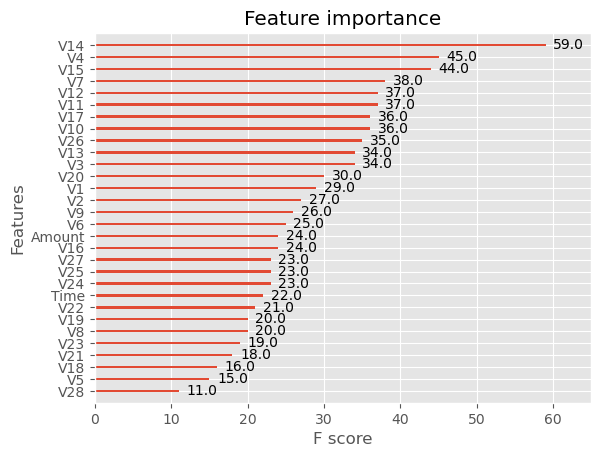

In [31]:
print('\nBest parameters found:\n')  
print(best_params)

print('\nEvaluation on the test dataset\n')  

best_f_score,best_model=do_train(best_params, param, dtrain,'train',trainY,dtest,'test',testY,print_conf_matrix=True)


print('\nF-score on the test dataset: {:6.2f}'.format(best_f_score))


f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(8,5))
ax1.plot(results['F-Score'])
ax2.plot(results['Best F-Score'])
ax1.set_xlabel('Iterations',fontsize=11)
ax2.set_xlabel('Iterations',fontsize=11)
ax1.set_ylabel('F-Score',fontsize=11)
ax2.set_ylabel('Best F-Score',fontsize=11)
ax1.set_ylim([0.7,0.9])
ax2.set_ylim([0.7,0.9])
plt.tight_layout()
plt.show()


print('\nVariables importance:\n')  

p = xgb.plot_importance(best_model) 
plt.show()